# Yardage Prediction using NN Model
### Train model to predict Yardage for a given offense/defense team formations

In [16]:
# import libraries - updated
# import pandas as pd 
# import numpy as np
# from datetime import datetime

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score #  mean_squared_error,
import tensorflow as tf
from sklearn.model_selection import train_test_split


import importlib
import features_engineering
importlib.reload(features_engineering)
#!pip install tensorflow

<module 'features_engineering' from '/Users/lighttiger/async_workspace/bsc-projects/nfl2024-analytics/final-model-training-notebook/features_engineering.py'>

In [17]:
import importlib
import helpers 
importlib.reload(helpers)

<module 'helpers' from '/Users/lighttiger/async_workspace/bsc-projects/nfl2024-analytics/final-model-training-notebook/helpers.py'>

## Load the Data

In [18]:
df = helpers.prepare_and_load_df(loadFromFile=True)
df.head(2)


Load from path!


,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore,_winnerTeamAbbr,...,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,height,weight,birthDate,collegeName,position,displayName,any_motion
0,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31,BUF,...,NaN,NaN,NaN,6-5,325,1988-06-06,Indiana,G,Rodger Saffold,False
1,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31,BUF,...,NaN,NaN,NaN,6-6,305,1992-04-21,Missouri,C,Mitch Morse,False


In [41]:
# df.to_csv("files/data.csv", index=False)
#df.down
df.yardlineNumber.unique().max()

50

# Select Columns

In [20]:
# List of columns to convert into an array
columns = ['gameId', 'playId',
    "quarter", "down", "yardsToGo", "possessionTeam", "defensiveTeam",
     "yardlineNumber", "gameClock", "absoluteYardlineNumber",
    "offenseFormation", "receiverAlignment", "yardsGained", "pff_passCoverage",
    "_global_game_time", "_game_time_bucket", "time", "playDirection", "redZone"
]

# Select Columns
df[columns].head()

,gameId,playId,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineNumber,gameClock,absoluteYardlineNumber,offenseFormation,receiverAlignment,yardsGained,pff_passCoverage,_global_game_time,_game_time_bucket,time,playDirection,redZone
0,2022090800,692,1,1,10,BUF,LA,32,01:25,42,SHOTGUN,2x1,3,Cover-3 Seam,85,0,2022-09-09 00:45:46.9,left,False
1,2022090800,692,1,1,10,BUF,LA,32,01:25,42,SHOTGUN,2x1,3,Cover-3 Seam,85,0,2022-09-09 00:45:46.9,left,False
2,2022090800,692,1,1,10,BUF,LA,32,01:25,42,SHOTGUN,2x1,3,Cover-3 Seam,85,0,2022-09-09 00:45:46.9,left,False
3,2022090800,692,1,1,10,BUF,LA,32,01:25,42,SHOTGUN,2x1,3,Cover-3 Seam,85,0,2022-09-09 00:45:46.9,left,False
4,2022090800,692,1,1,10,BUF,LA,32,01:25,42,SHOTGUN,2x1,3,Cover-3 Seam,85,0,2022-09-09 00:45:46.9,left,False


### Create new DataFrame with one Row per Play

In [21]:
newdf = df.groupby(['gameId', 'playId']).first().reset_index()
newdf.head(2)

,gameId,playId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore,...,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,height,weight,birthDate,collegeName,position,displayName,any_motion
0,2022090800,56,2022,1,9/8/2022,20:20:00,LA,BUF,10,31,...,HCR,47879.0,47857.0,6-5,325,1988-06-06,Indiana,G,Rodger Saffold,False
1,2022090800,80,2022,1,9/8/2022,20:20:00,LA,BUF,10,31,...,HCR,42489.0,NaN,6-5,325,1988-06-06,Indiana,G,Rodger Saffold,False


### Add Column Distance to Goal 

# Selected Columns

In [22]:
# List of columns to convert into an array
SELECTED_COLUMNS = [ 
    "offenseFormation", "receiverAlignment", "pff_passCoverage", 
    "down", "possessionTeam", "defensiveTeam",
    "quarter", 'gameClock', # later convert _time_remaining_in_game
    "yardlineNumber" , "playDirection", # later convert into _distance_to_goal
    "yardsGained", # => Target 
]

In [23]:
dataset = newdf[SELECTED_COLUMNS].copy()
dataset.head(2)

,offenseFormation,receiverAlignment,pff_passCoverage,down,possessionTeam,defensiveTeam,quarter,gameClock,yardlineNumber,playDirection,yardsGained
0,SHOTGUN,2x2,Cover 6-Left,1,BUF,LA,1,15:00,25,left,6
1,EMPTY,3x2,Cover 6-Left,2,BUF,LA,1,14:29,31,left,7


In [30]:
#dataset.to_csv("files/dataset.csv", index=False)

# Feature Selection and Engineering

Columns:

- quarter: Game quarter (numeric)
- gameClock: Time on clock of play (MM:SS)
- down: Down (numeric)
- possessionTeam: Team abbr of team on offense with possession of ball (text)
- defensiveTeam: Team abbr of team on defense (text)
- offenseFormation: Formation used by possession team (text)
- receiverAlignment: Enumerated as 0x0, 1x0, 1x1, 2x0, 2x1, 2x2, 3x0, 3x1, 3x2 (text)
- pff_passCoverage: The pass coverage concept employed by the defense on the play (text)
- _distance_to_goal: Calculated based on 'yardlineNumber' and 'playDirection'
- yardsGained (Target): Net yards gained by the offense, including penalty yardage (numeric)


### Data Transformation 

- quarter, gameClock : Transform into time remaining feature (_time_remaining_in_game) \n
timeRemainingInGame=(4−quarter)×15+gameClock
- down: Treat as numeric. No transformation needed; Standarize data
- possessionTeam, defensiveTeam: On-hot encoding for categorical variables.
- offenseFormation, receiverAlignment, pff_passCoverage: On-hot encoding for categorical variables.
- _distance_to_goal: Numeric data, No transformation needed; Standarize data
- yardsGained: Target variable. No transformation;  

## Top 3 Regression Models to Consider
- Gradient Boosting Regressor (e.g., XGBoost, LightGBM): Handles mixed data types well and excels with structured data.
- Random Forest Regressor: Robust to outliers and effective with limited feature engineering.
- Linear Regression (or Ridge/Lasso Regression): Useful for benchmarking; may perform well with proper feature encoding and transformations.

In [25]:
dataset.columns

Index(['offenseFormation', 'receiverAlignment', 'pff_passCoverage', 'down',
       'possessionTeam', 'defensiveTeam', 'quarter', 'gameClock',
       'yardlineNumber', 'playDirection', 'yardsGained'],
      dtype='object')

# Steps

- Split your data into training, validation, and testing sets to avoid data leakage. 
- Then perform feature engineering on the training set. 
- Finally, apply scaling after feature engineering to ensure the scaler is fitted only on the training data and then applied consistently to the validation and test sets.








# Split Data into Training & Testing Data
Do the split before doing feature engineering, to guarnetee getting stratified datasets for training and testing based on PossisionTeam.


- Split the dataset DataFrame into training and testing sets first based on possessionTeam.
- This ensures that the saturation based on possessionTeam is maintained in both the training and testing sets, even before any transformations or feature engineering steps are applied.

### Clean the Data

In [26]:
# Remove Outliers from Data
import importlib
import features_engineering
importlib.reload(features_engineering)
dataset = features_engineering.remove_outliers_by_team(dataset, 'yardsGained', 'possessionTeam')
features_engineering.df_cleaning(df=dataset, columns=SELECTED_COLUMNS, inplace=True)

In [27]:
dataset.shape

(14989, 11)

# Split Data into Training, Testing and Validaiton Sets

In [28]:

# Extracting the 'possessionTeam' column from dataset for stratification
possession_team_labels = dataset['possessionTeam'].values

# Step 1: Split into training (80%) and temporary set (20%)
train_df, temp_df = train_test_split(dataset, 
                                     test_size=0.2, 
                                     random_state=42, 
                                     stratify=possession_team_labels)

# Step 2: Split the temporary set (temp_df) into validation (50% of the temporary set) and testing (50% of the temporary set)
valid_df, test_df = train_test_split(temp_df, 
                                     test_size=0.5, 
                                     random_state=42, 
                                     stratify=temp_df['possessionTeam'])

# Target columns
# Extract target column ('yardsGained') from train_df, valid_df, and test_df
train_target = train_df['yardsGained'].values
valid_target = valid_df['yardsGained'].values
test_target = test_df['yardsGained'].values

# Feature Engineering


In [ ]:
# Now apply the feature engineering and prepare the data for all three sets
train_prepared_data, train_prepared_df = features_engineering.create_prepared_numpy_array_multi_scaler(df=train_df, load_scaler=False)
valid_prepared_data, valid_prepared_df = features_engineering.create_prepared_numpy_array_multi_scaler(df=valid_df, load_scaler=True)
test_prepared_data, test_prepared_df = features_engineering.create_prepared_numpy_array_multi_scaler(df=test_df, load_scaler=True)


In [ ]:
test_prepared_df.head(2)

,down,_time_remaining_in_game,_distance_to_goal,possessionTeam_ARI,possessionTeam_ATL,possessionTeam_BAL,possessionTeam_BUF,possessionTeam_CAR,possessionTeam_CHI,possessionTeam_CIN,...,pff_passCoverage_2-Man,pff_passCoverage_Goal Line,pff_passCoverage_Cover-0,pff_passCoverage_Cover-3 Double Cloud,pff_passCoverage_Prevent,pff_passCoverage_Bracket,pff_passCoverage_Cover-3 Cloud Right,pff_passCoverage_Cover-3 Cloud Left,pff_passCoverage_Cover-1 Double,pff_passCoverage_Miscellaneous
0,2.0,-0.762519,-0.738095,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.493142,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train Neural Network

#

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from tensorflow.keras import backend as K

tf.get_logger().setLevel('ERROR')

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler

Epoch 1/1000
188/188 [==============================] - 2s 2ms/step - loss: 49.6304 - val_loss: 46.3468 - lr: 5.0000e-04
Epoch 2/1000
188/188 [==============================] - 0s 2ms/step - loss: 45.5827 - val_loss: 43.4073 - lr: 5.0000e-04
Epoch 3/1000
188/188 [==============================] - 0s 1ms/step - loss: 42.3923 - val_loss: 40.4431 - lr: 5.0000e-04
Epoch 4/1000
188/188 [==============================] - 0s 1ms/step - loss: 39.4972 - val_loss: 37.6596 - lr: 5.0000e-04
Epoch 5/1000
188/188 [==============================] - 0s 2ms/step - loss: 37.2275 - val_loss: 35.5482 - lr: 5.0000e-04
Epoch 6/1000
188/188 [==============================] - 0s 2ms/step - loss: 35.5684 - val_loss: 34.2146 - lr: 5.0000e-04
Epoch 7/1000
188/188 [==============================] - 0s 2ms/step - loss: 34.2918 - val_loss: 33.5835 - lr: 5.0000e-04
Epoch 8/1000
188/188 [==============================] - 0s 2ms/step - loss: 34.2264 - val_loss: 33.2800 - lr: 5.0000e-04
Epoch 9/1000
188/188 [==========

/Users/lighttiger/opt/anaconda3/envs/py38-ml/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 0s 854us/step
Neural Network Validation RMSE: 5.684936449798089
Neural Network Validation R-squared: 0.004162795969519517
47/47 [==============================] - 0s 890us/step
******************
Neural Network Test RMSE: 5.569021151281221
Neural Network Test R-squared: 0.01620482007554036


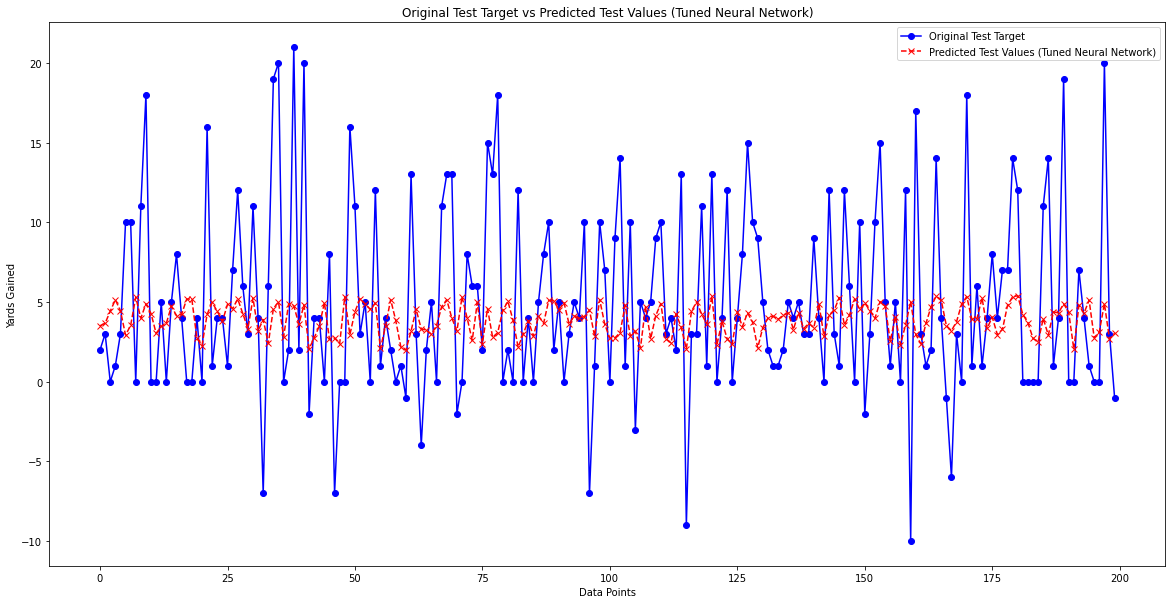

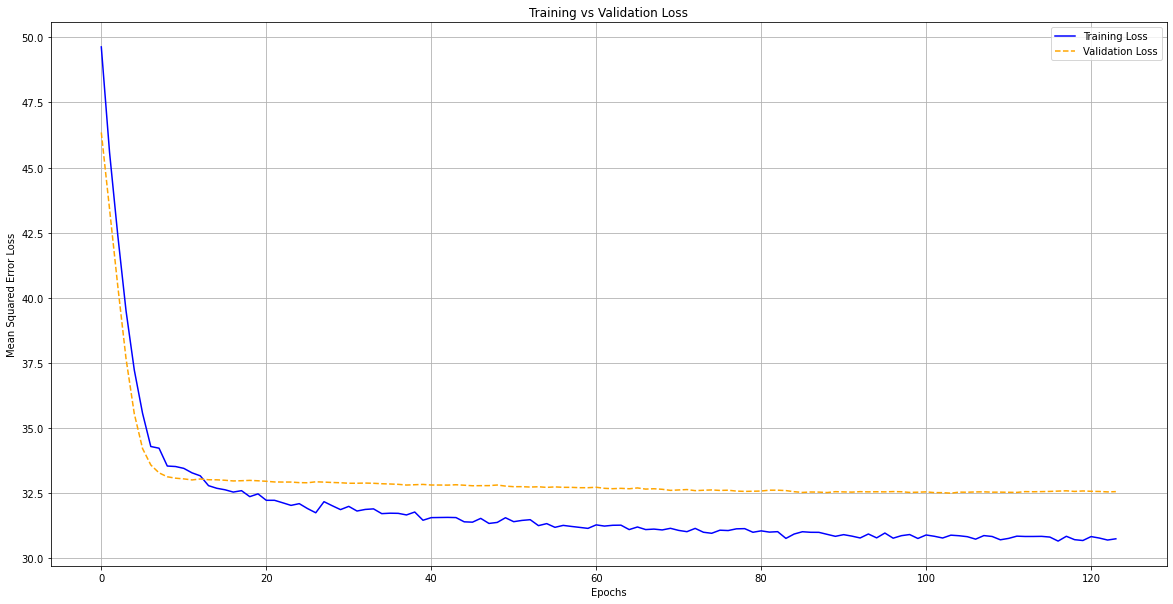

In [ ]:



"""
 Reduce Model Complexity (Reduce Layer Size)
Reducing the complexity of the model. Reducing the number of neurons in the layers:
"""

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_dim=train_prepared_data.shape[1], activation='tanh', kernel_regularizer=l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),  # Increased dropout rate
    tf.keras.layers.Dense(16, activation='tanh', kernel_regularizer=l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),  # Increased dropout rate
    tf.keras.layers.Dense(1, activation='linear')
])


# Compile model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6)

# Train the model
history = model.fit(
    train_prepared_data,
    train_target,
    epochs=1000,
    batch_size=64,
    validation_data=(valid_prepared_data, valid_target),
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the Model 
model.save('model/tuned_neural_network_model.h5')

# Evaluate the model
valid_pred_nn = model.predict(valid_prepared_data)
valid_mse_nn = mean_squared_error(valid_target, valid_pred_nn)
valid_rmse_nn = np.sqrt(valid_mse_nn)
valid_r2_nn = r2_score(valid_target, valid_pred_nn)

print(f'Neural Network Validation RMSE: {valid_rmse_nn}')
print(f'Neural Network Validation R-squared: {valid_r2_nn}')

test_pred_nn = model.predict(test_prepared_data)
test_mse_nn = mean_squared_error(test_target, test_pred_nn)
test_rmse_nn = np.sqrt(test_mse_nn)
test_r2_nn = r2_score(test_target, test_pred_nn)

print("******************")
print(f'Neural Network Test RMSE: {test_rmse_nn}')
print(f'Neural Network Test R-squared: {test_r2_nn}')


# Step 7: Plot the results for the tuned model
npoints = 200
plt.figure(figsize=(20, 10))
plt.plot(test_target[:npoints], label='Original Test Target', color='blue', linestyle='-', marker='o')
plt.plot(test_pred_nn[:npoints], label='Predicted Test Values (Tuned Neural Network)', color='red', linestyle='--', marker='x')

plt.xlabel('Data Points')
plt.ylabel('Yards Gained')
plt.title('Original Test Target vs Predicted Test Values (Tuned Neural Network)')
plt.legend()

plt.show()


# Validation ------------
 # Plot the training and validation loss
plt.figure(figsize=(20, 10))

# Extract loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the loss values
plt.plot(training_loss, label='Training Loss', color='blue', linestyle='-')
plt.plot(validation_loss, label='Validation Loss', color='orange', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


Epocks = 300, early stopping=30

- Neural Network Test RMSE: 8.515010550154901
- Neural Network Test R-squared: 0.0021350330686688013

After Removing Outliers 
- Neural Network Test RMSE: 5.591314039024247
- Neural Network Test R-squared: 0.008312757442314966

Drop out, reguralization, batch normalization 
- Neural Network Test RMSE: 5.564013067676245
- Neural Network Test R-squared: 0.017973430050149064-

LeakyReLu 
- Neural Network Test RMSE: 5.565937612736172
- Neural Network Test R-squared: 0.01729396319033405


More Layers 
- Neural Network Test RMSE: 5.608900210902726
- Neural Network Test R-squared: 0.0020647059574220306

Pearson Correlation Coefficient: 0.1417
P-value: 0.0000
Interpretation of Correlation: Weak positive correlation: The model's predictions have some accuracy but could be improved.
Interpretation of P-value: The correlation is statistically significant (p-value < 0.05), indicating the relationship is unlikely to have occurred by chance.


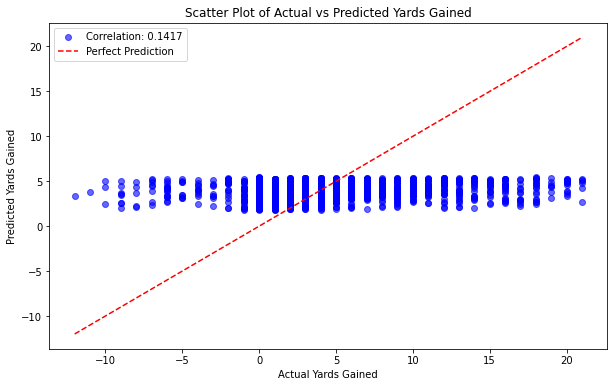

(array([0.14172960991625114], dtype=object), 3.5762222928673904e-08)

In [ ]:
import importlib
import features_eng
importlib.reload(features_eng)
features_eng.evaluate_predictions(test_target, test_pred_nn)

- Pearson Correlation Coefficient (r = 0.1472): This value suggests that the relationship between the two variables is weak and positive. As one variable increases, the other tends to increase slightly, but the correlation is not strong.
- P-value (p = 0.0000): The p-value tests the null hypothesis that there is no correlation (i.e., the correlation coefficient is zero). A p-value of 0 (or a very small value like 0.0000) indicates that the observed correlation is statistically significant and is highly unlikely to have occurred by chance. In other words, despite the weak correlation, the relationship is statistically significant.


# Load Model and Run Inference 

In [ ]:
MODEL_PATH = 'model/tuned_neural_network_model.h5'

def inference(df):
    from tensorflow.keras.models import load_model
    # Load the saved model
    loaded_model = load_model('model/tuned_neural_network_model.h5')

    # Data Preparation 
    prepared_data, prepared_df = features_engineering.create_prepared_numpy_array_multi_scaler(df=testdf, load_scaler=True)
    predictions = loaded_model.predict(prepared_data)
    return predictions


# Prepare the data 

testdf = dataset[:1].copy()
predictions = inference(testdf)

# Print predictions
print("Predicted values:", predictions)
print("Actual values:", testdf.yardsGained)


1/1 [==============================] - 0s 89ms/step
Predicted values: [[3.0044165]]
Actual values: 1384   -1
Name: yardsGained, dtype: int64


In [ ]:
testdf = dataset[:1].copy()
testdf

,offenseFormation,receiverAlignment,pff_passCoverage,down,possessionTeam,defensiveTeam,quarter,gameClock,yardlineNumber,playDirection,yardsGained
1384,PISTOL,2x2,Cover-3,1,ARI,KC,1,09:37,25,right,-1


In [ ]:
# List of columns to convert into an array
SELECTED_COLUMNS = [ 
    "offenseFormation", "receiverAlignment", "pff_passCoverage", 
    "down", "possessionTeam", "defensiveTeam",
    "quarter", 'gameClock', # later convert _time_remaining_in_game
    "yardlineNumber" , "playDirection", # later convert into _distance_to_goal
    "yardsGained", # => Target 
]